## Quantities & Prices (Wright 1934)



Consider a data generating process for $(q,p)$ based
on Goldberger (1972), who in turn is describing the work of Sewall
Wright (1934).  The demand-supply system is
$$
   q_D = \alpha p + u\qquad q_S = \beta p + v\qquad q_D = q_S,
$$
where $(u,v)$ are unobserved shocks to demand and supply,
respectively. 



In [1]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Structural parameters;
(α,β) = (-1,2)     
σ = {'u':1/2,'v':1/3}
μ = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=μ['u'], scale=σ['u'])  # Demand shocks
v = iid.norm(loc=μ['v'], scale=σ['v'])  # Supply shocks

# Reduced form coefficients
π = [[-β/(α - β), -1/(α - β)],
     [ α/(α - β), 1/(α - β)]]

# Generate N realizations of system
# Outcomes Y have columns (q,p)
N = 10

# Arrange shocks into an Nx2 matrix
U = np.c_[u.rvs(N), v.rvs(N)]

# Matrix product gives [q,p]; label by putting into df
df = pd.DataFrame(U@π,columns=['q','p'])
Udf = pd.DataFrame(U,columns=['u','v']) # For future reference

We can interrogate these data:



In [2]:
df

,q,p
0,1.130137,1.222643
1,0.992784,1.178504
2,1.312292,0.992536
3,0.727897,1.134445
4,0.434656,0.771652
5,1.039249,1.026984
6,1.173349,0.904064
7,1.035390,1.129861
8,0.882796,0.949435
9,1.264269,1.361008


And compute the linear correlation&#x2026;



In [3]:
df.corr()

,q,p
q,1.000000,0.511697
p,0.511697,1.000000


Or more generally the covariance matrix:



In [4]:
C=df.cov()
C

,q,p
q,0.069398,0.023189
p,0.023189,0.029594


From which we can calculate the linear regression coefficient
of $p = a + bq + e$:



In [5]:
C.loc['p','q']/C.loc['q','q']

0.33414966398259816

And learn about the probability density&#x2026;



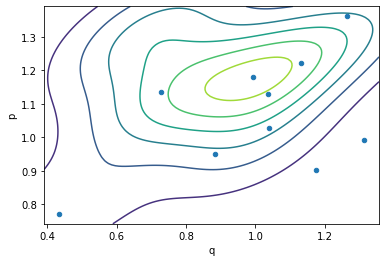

In [6]:
from scipy import stats
import numpy as np

# Estimate joint density of (q,p)
pdf = stats.gaussian_kde(df.T).pdf 

ax = df.plot.scatter(x='q',y='p')

v = ax.axis()
Q = np.mgrid[v[0]:v[1]:100j].tolist()
P = np.mgrid[v[2]:v[3]:100j].tolist()

_ = ax.contour(Q,P,np.array([[pdf((q,p))[0] for p in P] for q in Q]))

#### Counterfactual Demand & Supply Schedules



What are the actual *counterfactual* demand and
supply schedules?  This is the kind of thing that Frisch described as
&ldquo;hypothetical experiments.&rdquo;  The schedules respond to shocks $u$ and $v$, respectively,
yielding



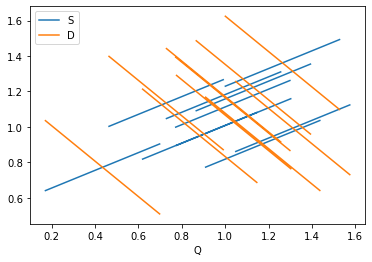

In [7]:
qmax = df['q'].max()
qmin = df['q'].min()

Q = pd.DataFrame({'min':np.maximum(0,df['q']-0.3*(qmax-qmin)),
                  'max':np.minimum(qmax*1.2,df['q']+0.3*(qmax-qmin)),
                  'miss':-1})

# Inverse counterfactual demand & supply (for plotting)
D = Q.add(-Udf['u'],axis=0)/α  
S = Q.add(-Udf['v'],axis=0)/β

counterfactual=pd.DataFrame({'S':S.stack(),
                             'D':D.stack(),
                             'Q':Q.stack()})

counterfactual=counterfactual.replace(-1,np.nan)

_ = counterfactual.plot(x='Q')

#### Controlling Price



Consider the question: what would expected demand be if we *fixed*
    the price at $p_0$?  Expected supply?



#### Average Causal Effect of a Change in Price



What would expected demand be if we *observed* that the price was $p_0$?



#### Price Change *Ceteris Paribus*



Suppose we *observe* prices and quantities $(p_0,q_0)$.  How *would*
    we expect the quantity demanded to change if prices were instead
    fixed at $p_1$, *ceteris paribus*?

